# Ex 1

## Point 1.a

In [1]:
fun <- function(theta){
    return ((1/2)*exp(-(theta+3)**2/(2))+(1/2)*exp(-(theta-3)**2/(2)))
}

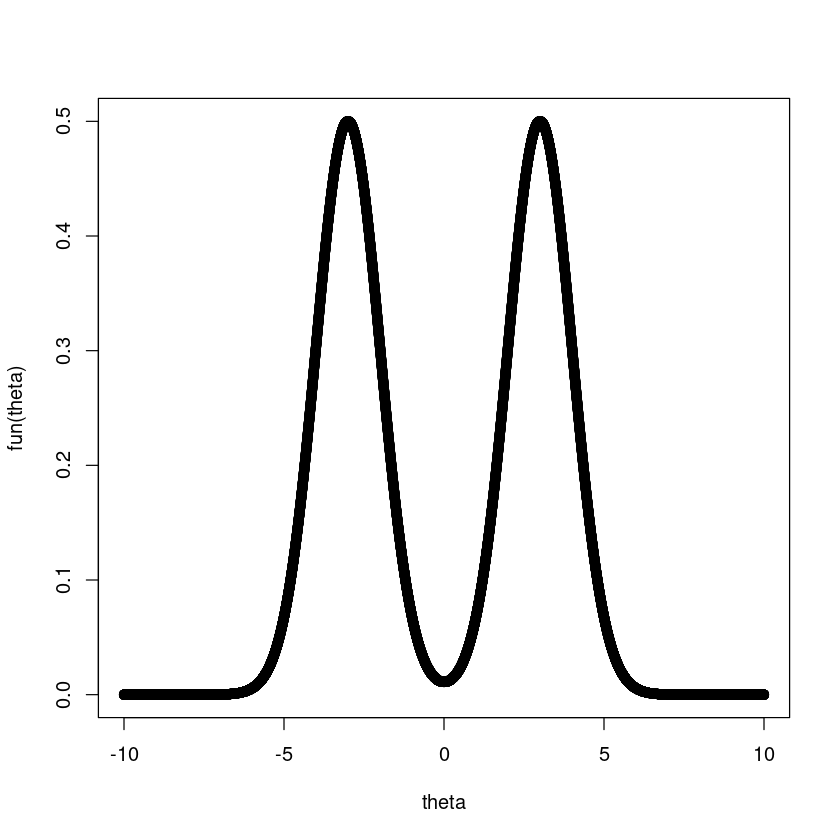

In [2]:
theta<-seq(-10,10,0.001)
plot(theta,fun(theta))

## Point 1.b,c

In [3]:
mc<-function(n_steps,init,burn_in,thinning){
    history<-c(init)

    for (i in 1:((n_steps*thinning)+burn_in)){
        #cat("\nnum_extraction:",i)
        candidate=rnorm(n=1,mean = history[i],sd = 1)
        #cat("\ncandidate:",candidate)
        prob=min(1,((fun(candidate)/fun(history[i]))*((dnorm(history[i],mean = candidate,sd = 1))/(dnorm(candidate, mean=history[i], sd=1)))))
        #cat("\nprob:",prob)
        sample=runif(n = 1,min = 0,max = 1)
        #cat("\nsample:",sample)
        if(sample<prob){
            history<-append(history,candidate)
        }
        else{
            history<-append(history,history[i])
        }
        #cat("\nhistory:",history,"\n\n\n")
    }
    history_burned <- history[seq(burn_in+1,length(history))]
    history_thinned <- history[seq(1, length(history_burned), by = thinning)]
    return (history_thinned)
}

In [4]:
n_steps=100000
init=0

history<-mc(n_steps=n_steps,init=init,burn_in=0,thinning=1)
print(length(history))

[1] 100001


In [5]:
history<-mc(n_steps=n_steps,init=init,burn_in=100,thinning=2)
print(length(history))

[1] 100001


## Point 1.d

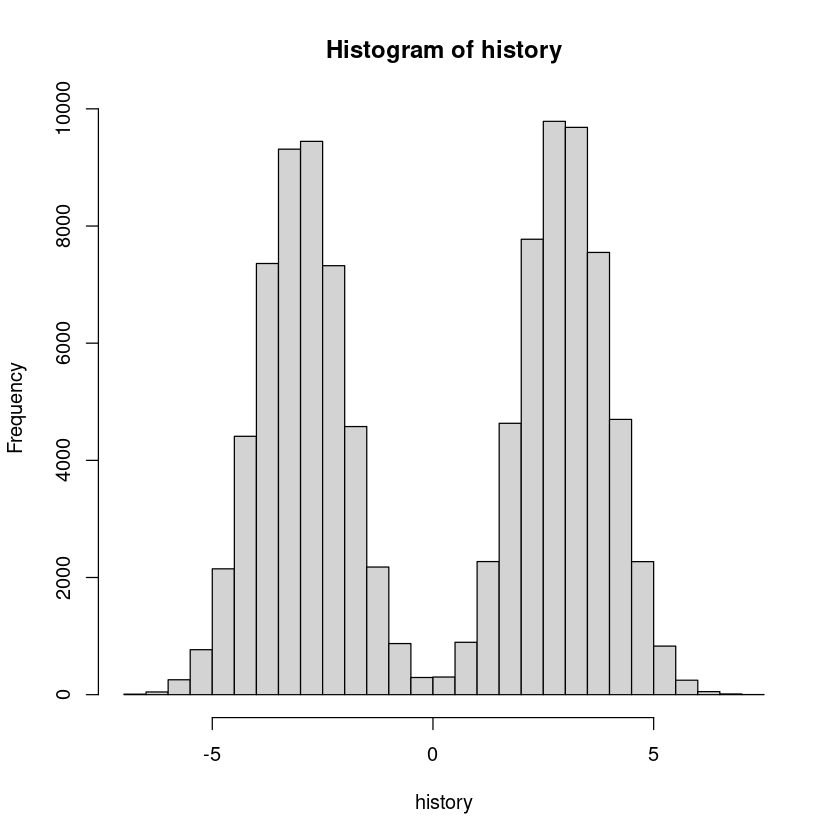

In [6]:
hist(history,breaks = 50)

## Point 1.e

In [7]:
library(coda)

In [8]:
history_mcmc <- as.mcmc(history)
cat("\nEffective size: ", effectiveSize(history_mcmc))


Effective size:  708.591

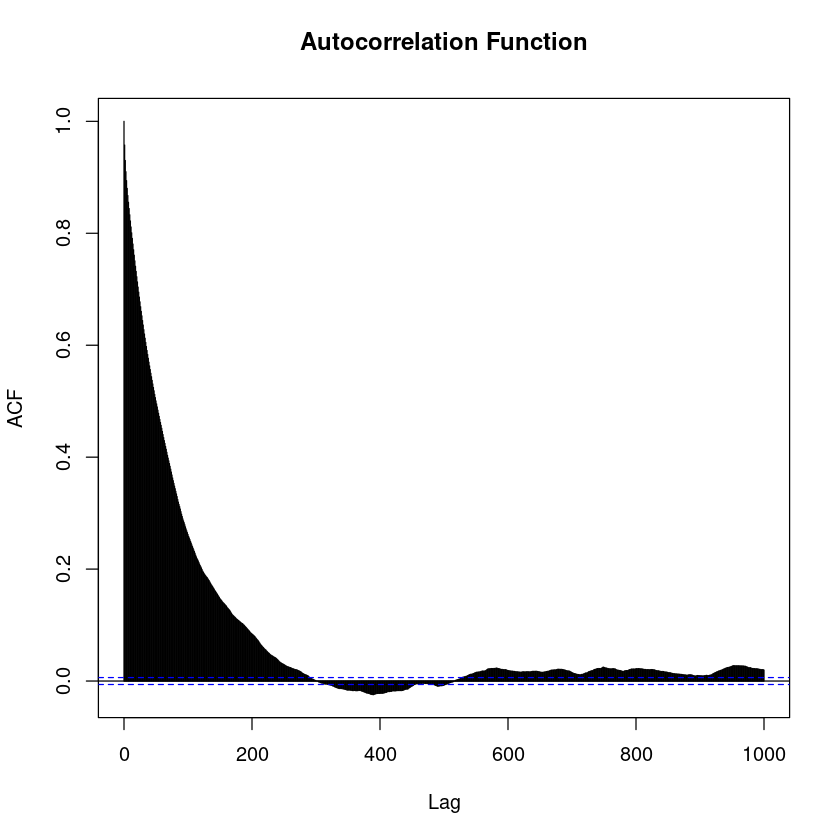

In [9]:
lags = seq(0,1000,10)
acf(as.vector(history_mcmc), lag.max = max(lags), main = "Autocorrelation Function")

In [10]:
burn_in <- c(50,100,250,500,1000,2000,5000)
thin_interval <- c(1,5,10,15,20)

n_steps=10000
effective_sizes <- matrix(data = NA, nrow = length(burn_in), ncol = length(thin_interval))
best_eff_size <- 100000
best_history <- NA
best_burn_in <- 0
best_thinning <- 0


for (i in 1:length(burn_in)){
    for (j in 1:length(thin_interval)){
        history_mcmc <- as.mcmc(mc(n_steps=n_steps,init=init,burn_in = burn_in[i],thinning = thin_interval[j]))
        effective_sizes[i,j] <- effectiveSize(history_mcmc)
        if ((effective_sizes[i,j]<best_eff_size)){
            best_eff_size <- effective_sizes[i,j]
            best_history <- history_mcmc
            best_burn_in <- burn_in[i]
            best_thinning <- thin_interval[j]
        }
    }
}

         [,1]     [,2]     [,3]     [,4]     [,5]
[1,] 42.57853 161.7444 349.2980 527.1512 626.6486
[2,] 32.65031 197.5127 329.8685 510.6842 653.7276
[3,] 45.25704 182.1294 335.0075 459.3289 754.5214
[4,] 29.55772 149.8546 365.7613 516.8568 683.7070
[5,] 40.08590 183.0734 333.5887 494.4136 582.3719
[6,] 29.71845 168.5706 365.6125 463.3841 578.6303
[7,] 28.98934 172.9580 337.6427 456.8228 621.1902


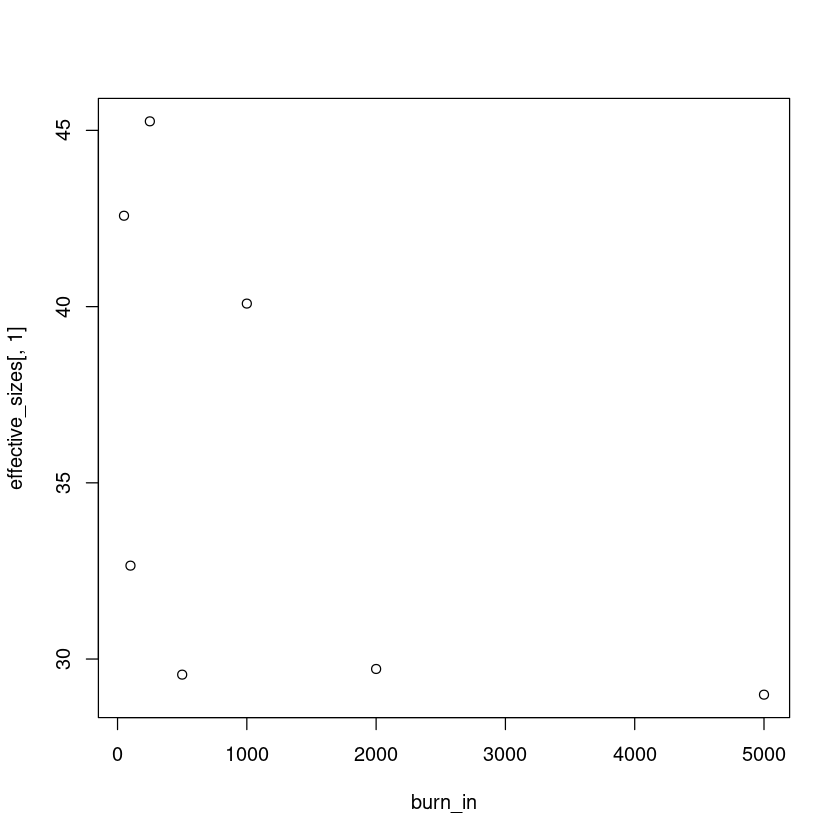

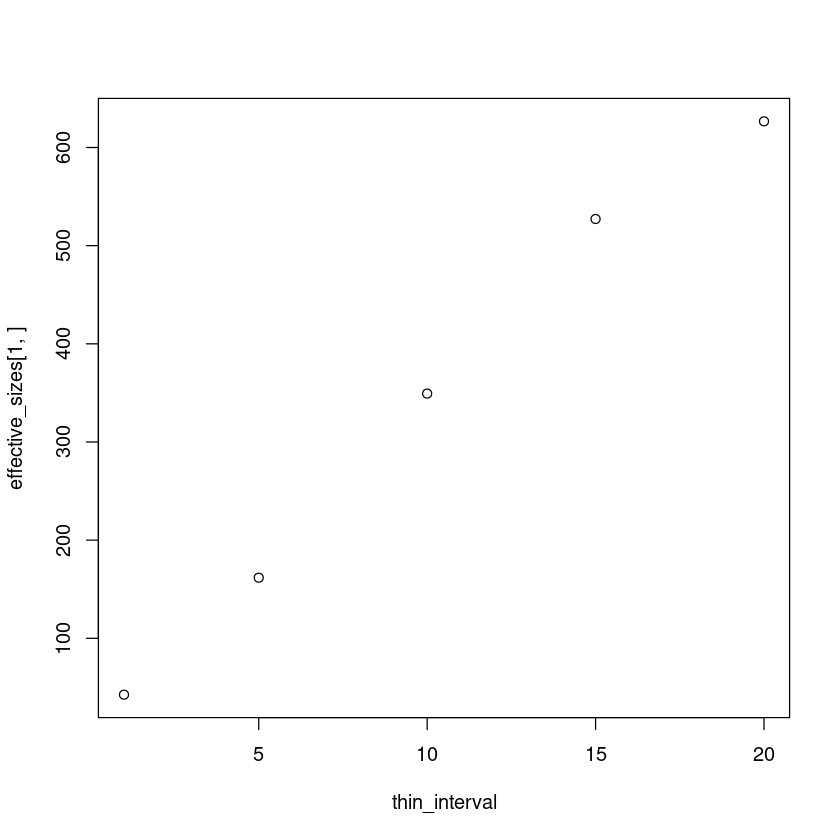


Best Effective Size:  28.98934
Best Burn In value:  5000
Best Thinning value:  1

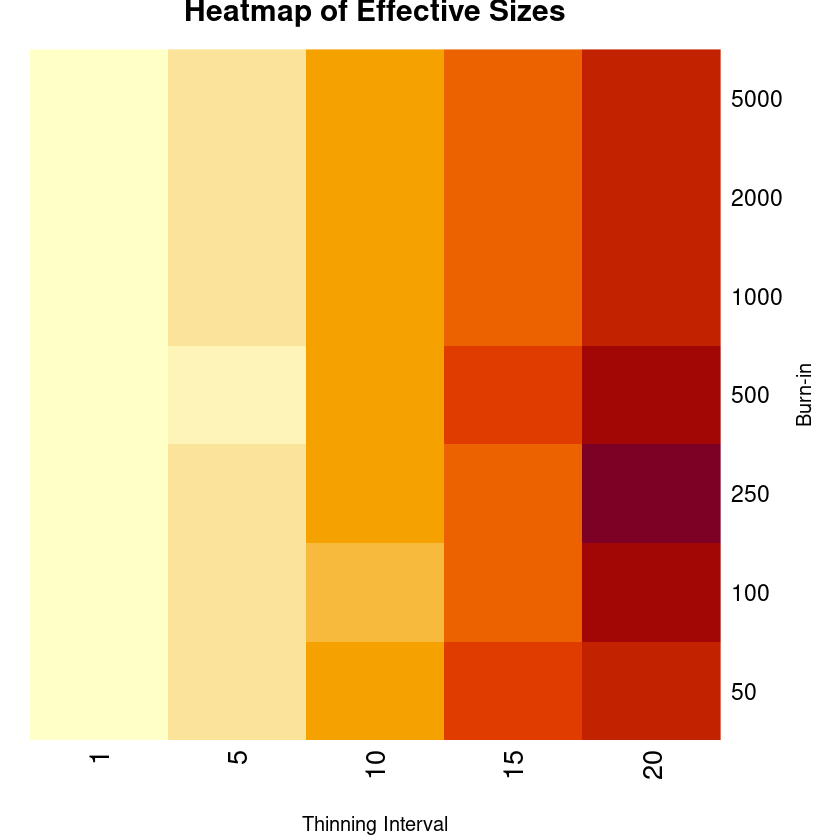

[1] 10001

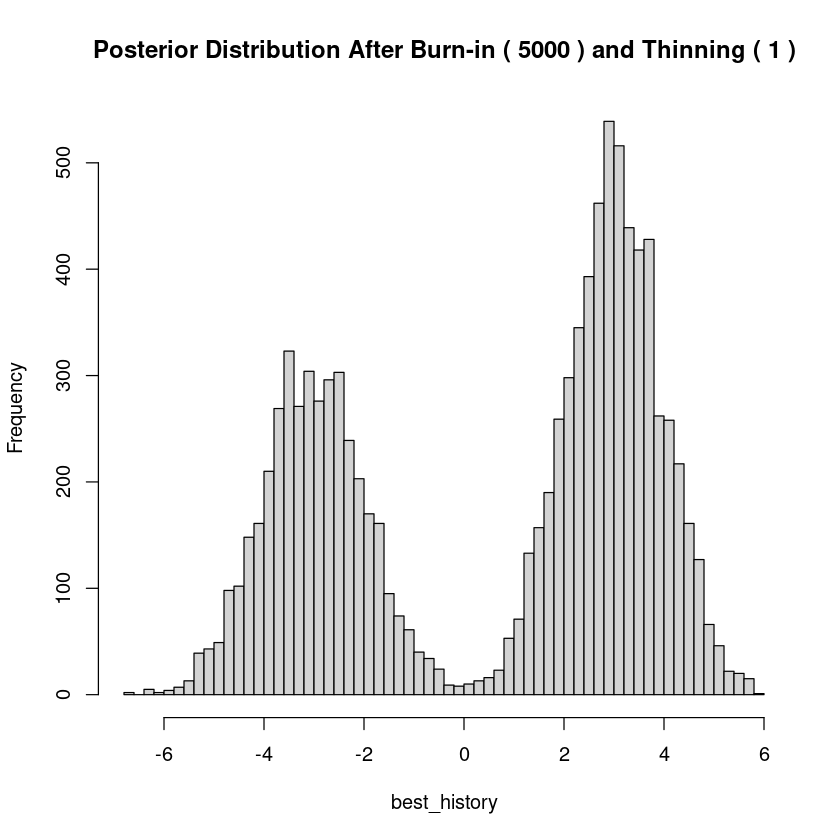

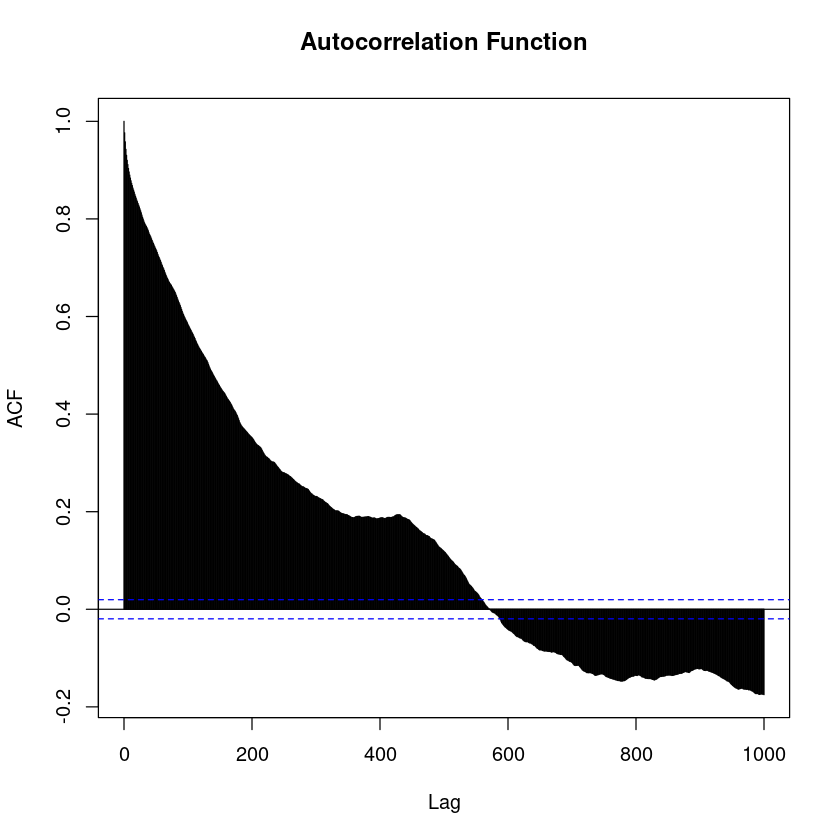

In [38]:

print(effective_sizes)
plot(burn_in,effective_sizes[,1])
plot(thin_interval,effective_sizes[1,])
heatmap(effective_sizes, Rowv = NA, Colv = NA, scale = "none", 
        main = "Heatmap of Effective Sizes", xlab = "Thinning Interval", ylab = "Burn-in", labRow=burn_in,labCol=thin_interval)

cat("\nBest Effective Size: ",best_eff_size)
cat("\nBest Burn In value: ",best_burn_in)
cat("\nBest Thinning value: ",best_thinning)
hist(best_history, breaks = 50, main = paste("Posterior Distribution After Burn-in (",best_burn_in, ") and Thinning (",best_thinning,")"))

length(best_history)
best_history_mcmc <- mcmc(best_history)
lags = seq(0,1000,10)
acf(as.vector(best_history_mcmc), lag.max = max(lags), main = "Autocorrelation Function")

# Ex 2

## Point 2.a

In [12]:
library(R2jags)

Loading required package: rjags

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




In [13]:
#data
Y <- c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)
X <- c(5, 6, 7, 8, 9, 10, 11, 12)

df <- data.frame(X, Y)

print(df)


   X       Y
1  5  -7.821
2  6  -1.494
3  7 -15.444
4  8 -10.807
5  9 -13.735
6 10 -14.442
7 11 -15.892
8 12 -18.326


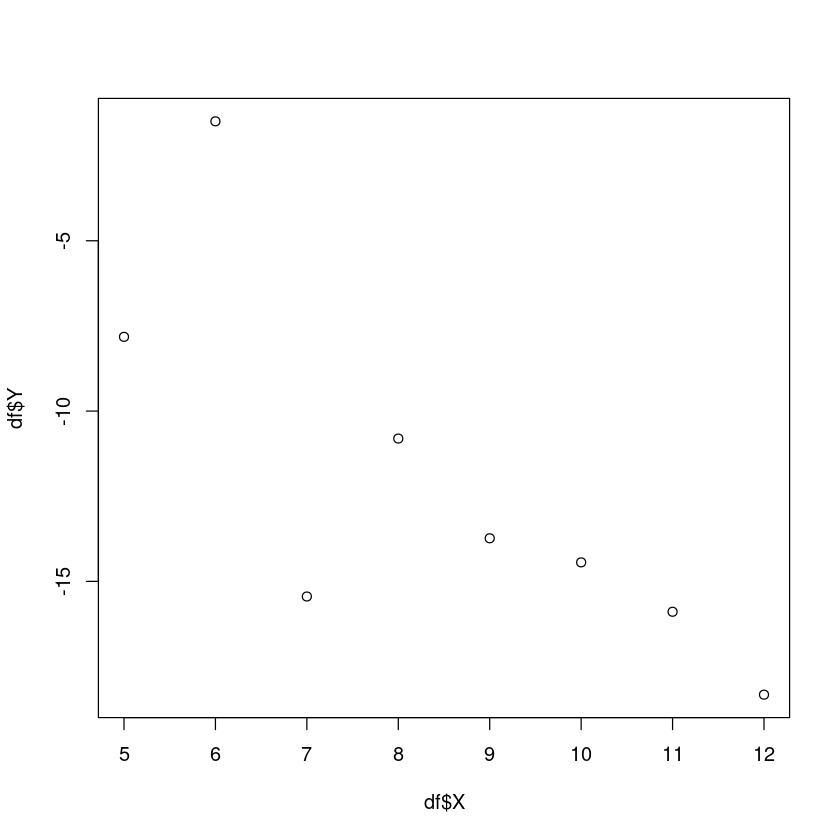

In [14]:
plot(df$X,df$Y)

In [15]:
jagsdata <- with(df, list(X = X, Y = Y, N = length(Y)))

In [16]:
mc_jags <- function(){
	#
	for (i in 1:N){
		Y[i] ~ dnorm(Z[i], c) # tau is precision (1 / variance)
		Z[i] <- a + b * X[i]
	}
	# Priors:
	a ~ dunif(1, 10) # intercept
	b ~ dunif(-1, 3) # slope
	c ~ dunif(0.034, 4) # standard deviation
}

In [17]:
init_values <- function(){
	list(a = runif(1,1,10), b = runif(1,-1,3), c = runif(1,0.034,4))
}

params <- c("a", "b", "c")

fit <- jags(data = jagsdata, inits = init_values, parameters.to.save = params, model.file = mc_jags,
			   n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)
fit

module glm loaded

module dic loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 42

Initializing model



Inference for Bugs model at "/tmp/RtmpZutD3Z/modela72456cd68720.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect   2.5%    25%    50%    75%  97.5%  Rhat n.eff
a   1.492   0.467  1.013  1.151  1.355  1.696  2.756 1.001  3000
b  -0.949   0.049 -0.998 -0.984 -0.963 -0.929 -0.816 1.003  3000
c   0.044   0.010  0.034  0.037  0.041  0.048  0.070 1.001  3000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

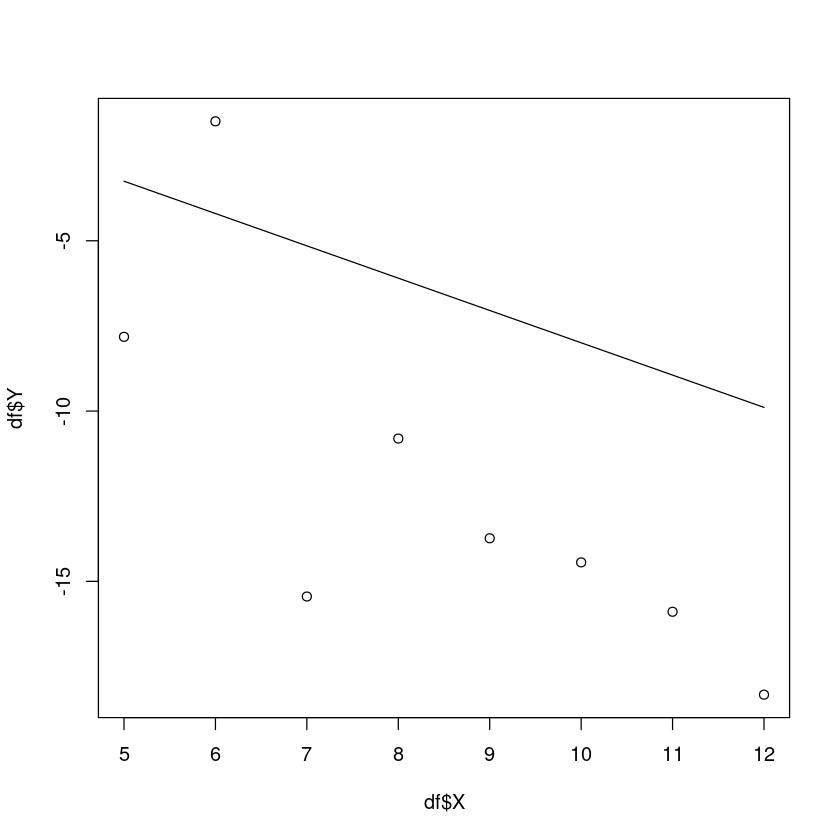

In [18]:
fit_params<-as.data.frame(fit$BUGSoutput$summary)["mean"]

x_fit<-seq(min(df$X),max(df$X),by = 0.01)
y_fit<-fit_params[1,] + fit_params[2,]*x_fit
plot(df$X,df$Y)
lines(x_fit,y_fit)

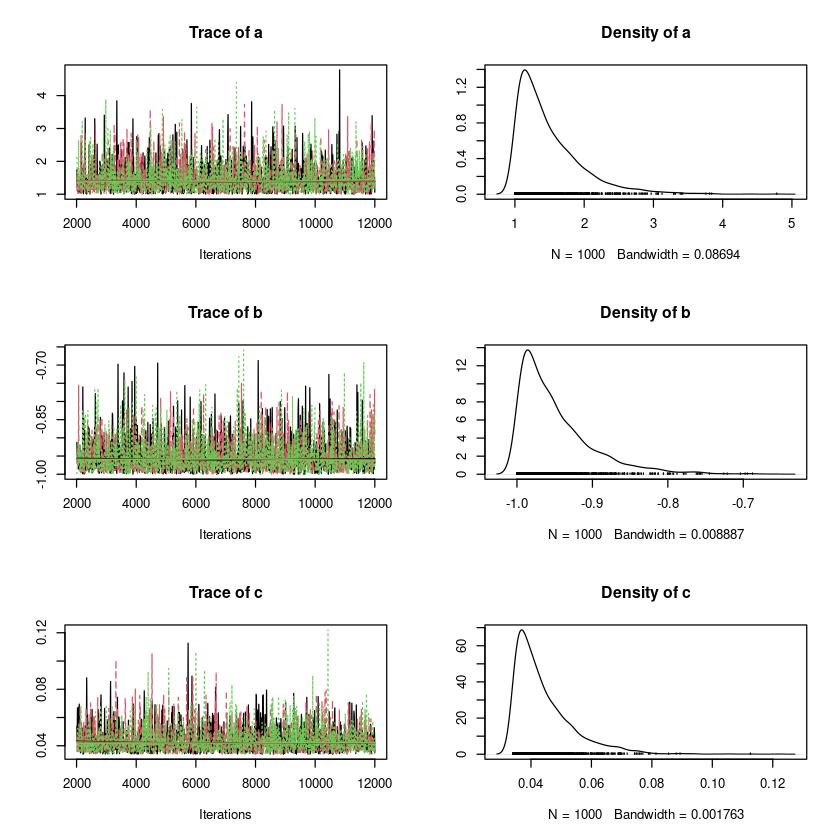

In [19]:
fit_chain<-as.mcmc(fit)
plot(fit_chain)

In [20]:
ninetyseven_half<-as.data.frame(fit$BUGSoutput$summary)["97.5%"]
two_half <-as.data.frame(fit$BUGSoutput$summary)["2.5%"]

cat("\na : ", fit_params[1,],"\t\t95% CI : ",two_half[1,],"-",ninetyseven_half[1,] )
cat("\nb : ", fit_params[2,],"\t95% CI : ",two_half[2,],"-",ninetyseven_half[2,] )
cat("\nc : ", fit_params[3,],"\t95% CI : ",two_half[3,],"-",ninetyseven_half[3,] )


a :  1.491693 		95% CI :  1.012768 - 2.755926
b :  -0.9486773 	95% CI :  -0.99842 - -0.8161715
c :  0.044169 	95% CI :  0.0343193 - 0.0695053

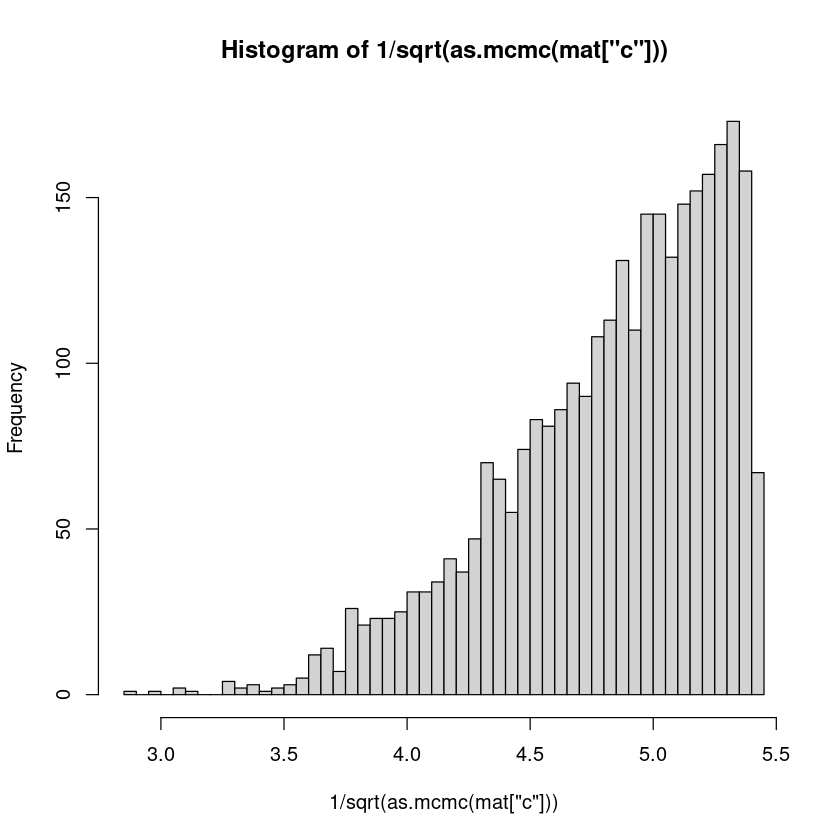

In [21]:
mat<-as.data.frame(fit$BUGSoutput$sims.matrix)
hist(1/sqrt(as.mcmc(mat["c"])),breaks = 50)

# Ex 3

## Point 3.a

In [22]:
X = c(2.06,5.56,7.93,6.56,205)

In [23]:
jagsdata <- list(X = X, N = length(X))

In [24]:
mc_jags <- function(){
	for (i in 1:N){
		X[i] ~ dnorm(m,s*s) 
	}
	m ~ dunif(-10, 10) 
    s ~ dunif(0, 50) 
}

In [25]:
init_values <- function(){
	list(m = runif(1,-10,10), s = runif(1,0,50))
}

params <- c("m", "s")

fit <- jags(data = jagsdata, inits = init_values, parameters.to.save = params, model.file = mc_jags,
			   n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)
fit

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 13

Initializing model



Inference for Bugs model at "/tmp/RtmpZutD3Z/modela72454edd15b9.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect   2.5%    25%   50%   75% 97.5%  Rhat n.eff
m   1.107   5.569 -9.032 -3.483 1.539 5.965 9.568 1.001  3000
s   0.011   0.003  0.005  0.009 0.011 0.014 0.019 1.001  3000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

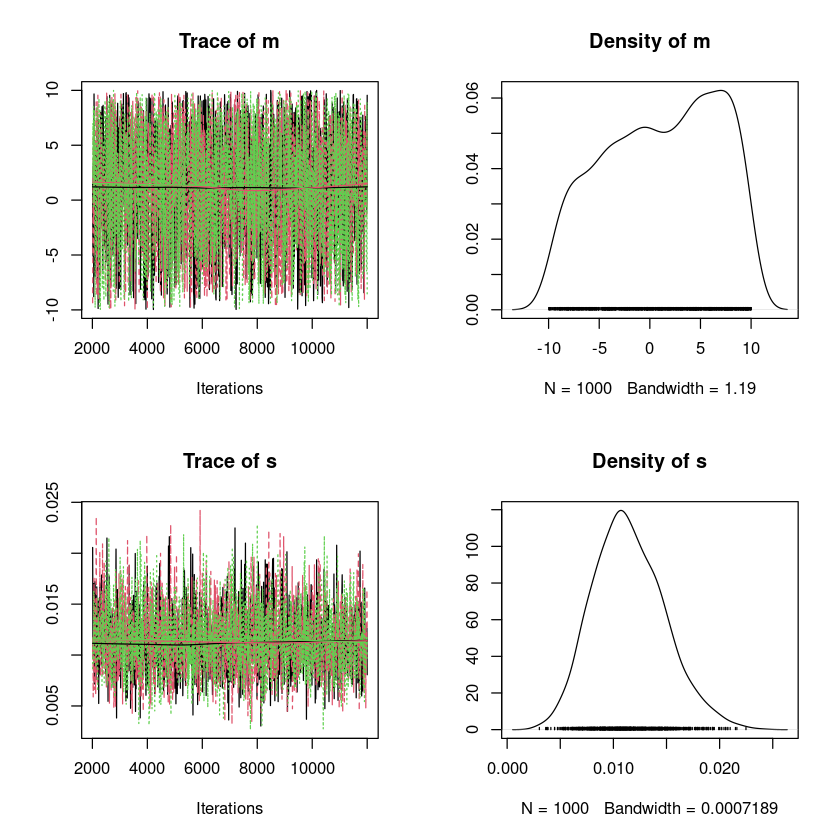

In [26]:
fit_chain<-as.mcmc(fit)
plot(fit_chain)

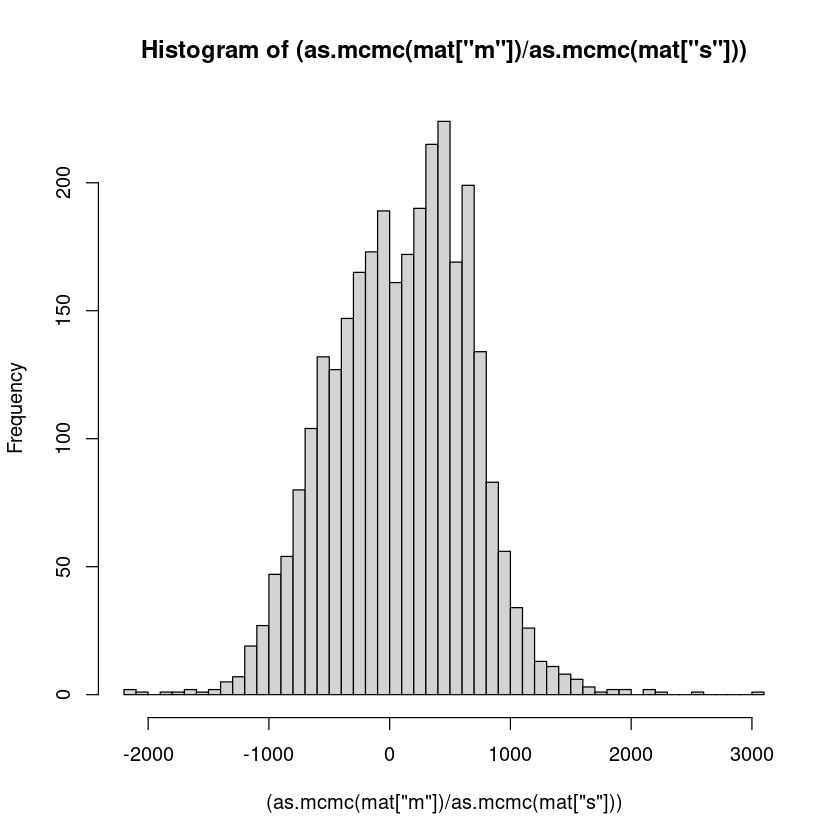

In [27]:
mat<-as.data.frame(fit$BUGSoutput$sims.matrix)
hist((as.mcmc(mat["m"])/as.mcmc(mat["s"])),breaks = 50)

# Ex 4

## Point 4.a

In [28]:
D <- c(0.0032, 0.0034, 0.214, 0.263, 0.275, 
       0.275, 0.45, 0.5, 0.5, 0.63, 
       0.8, 0.9, 0.9, 0.9, 0.9, 
       2, 2, 2, 2)

V <- c(170, 290, -130, -70, -185, 
       -220, 200, 290, 270, 200, 
       920, 450, 500, 500, 960, 
       500, 850, 800, 1090)

jagsdata <- list(D = D,V=V, N = length(D))

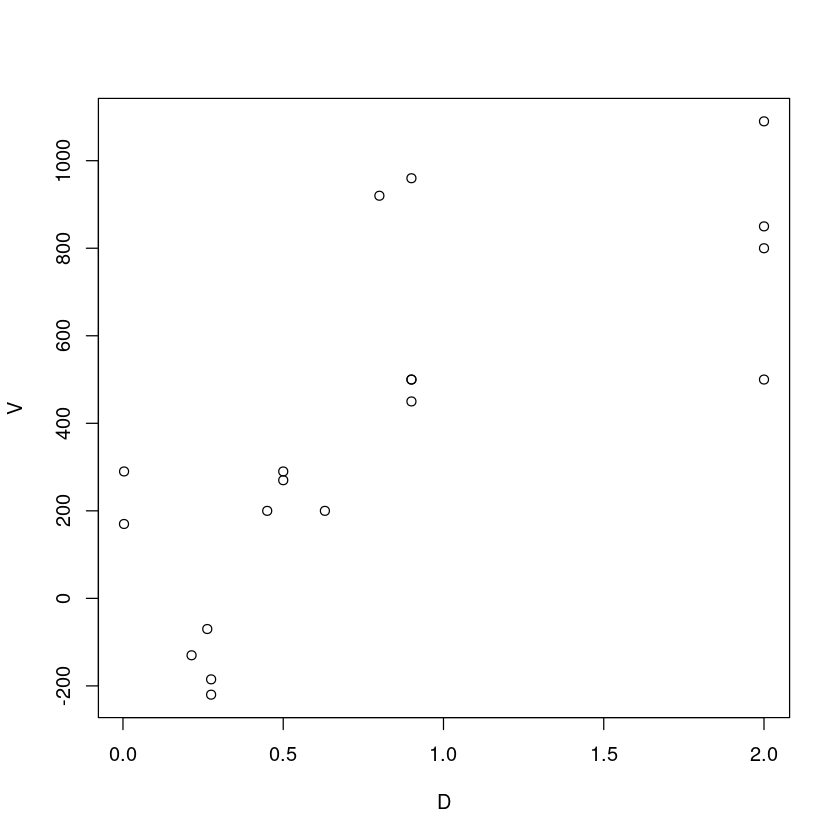

In [29]:
plot(D,V)

In [30]:
mc_jags <- function(){
	for (i in 1:N){
		V[i] ~ dnorm(b*D[i],c) 
	}
	b ~ dunif(-10, 1000) 
    c ~ dunif(0, 10) 
}

In [31]:
init_values <- function(){
	list(b = runif(1,-10,1000), c = runif(1,0,10))
}

params <- c("b", "c")

fit <- jags(data = jagsdata, inits = init_values, parameters.to.save = params, model.file = mc_jags,
			   n.chains = 3, n.iter = 12000, n.burnin = 2000, n.thin = 10, DIC = F)
fit

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 56

Initializing model



Inference for Bugs model at "/tmp/RtmpZutD3Z/modela7245388840a5.txt", fit using jags,
 3 chains, each with 12000 iterations (first 2000 discarded), n.thin = 10
 n.sims = 3000 iterations saved
  mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
b 457.123  56.475 347.293 420.258 457.152 494.353 568.844 1.001  3000
c   0.000   0.000   0.000   0.000   0.000   0.000   0.000 1.001  3000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

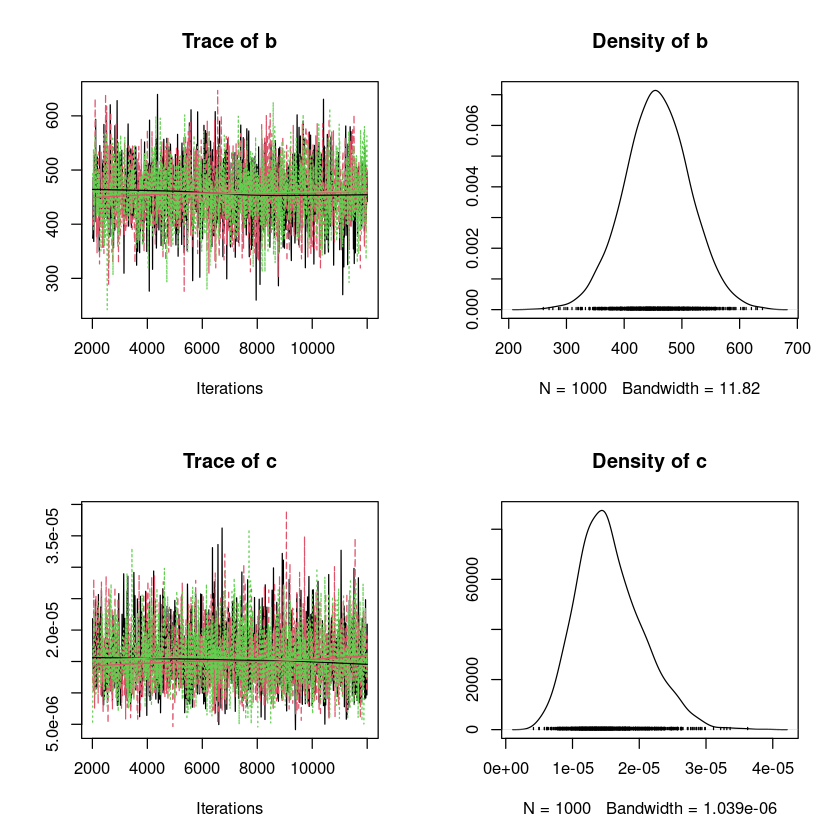

In [32]:
fit_chain<-as.mcmc(fit)
plot(fit_chain)

In [33]:
fit_params<-as.data.frame(fit$BUGSoutput$summary)["mean"]

ninetyseven_half<-as.data.frame(fit$BUGSoutput$summary)["97.5%"]
two_half <-as.data.frame(fit$BUGSoutput$summary)["2.5%"]

cat("\nb : ", fit_params[1,],"\t\t95% CI : ",two_half[1,],"-",ninetyseven_half[1,] )
cat("\nc : ", fit_params[2,],"\t95% CI : ",two_half[2,],"-",ninetyseven_half[2,] )


b :  457.1235 		95% CI :  347.2926 - 568.8443
c :  1.561678e-05 	95% CI :  7.550234e-06 - 2.63842e-05